# Imports

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
from sklearn.model_selection import train_test_split,ShuffleSplit,GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score,confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from tqdm import tqdm

# Data Analysis

In [72]:
ratings = pd.read_csv('./Book_Recommender/BX-Book-Ratings.csv',sep= ';', encoding = 'latin-1')
#,header=None,names=['User-ID','ISBN','Book-Rating'],skiprows=1000000

In [73]:
print(f'number of ratings: {ratings.shape[0]} \nnumber of features: {ratings.shape[1]}')
print(ratings.head())
print(list(ratings))
print(ratings.dtypes)
print(ratings.isnull().sum())

number of ratings: 1149780 
number of features: 3
   User-ID        ISBN  Book-Rating
0   276725  034545104X            0
1   276726  0155061224            5
2   276727  0446520802            0
3   276729  052165615X            3
4   276729  0521795028            6
['User-ID', 'ISBN', 'Book-Rating']
User-ID         int64
ISBN           object
Book-Rating     int64
dtype: object
User-ID        0
ISBN           0
Book-Rating    0
dtype: int64


In [74]:
user_id_counts = ratings['User-ID'].value_counts()
filtered_user_ids = user_id_counts[user_id_counts >= 250].index
ratings = ratings[ratings['User-ID'].isin(filtered_user_ids)]

isbn_counts = ratings['ISBN'].value_counts()
filtered_isbn = isbn_counts[isbn_counts >= 50].index
ratings = ratings[ratings['ISBN'].isin(filtered_isbn)]

In [75]:
ratings.shape[0]

31778

In [76]:
def Rating_Preprocessing(ratings):
    users=np.unique(ratings['User-ID'])
    print('unique users: ')
    print(np.size(users))
    print('unique ratings: ')
    print(np.size(np.unique(ratings['Book-Rating'])))
    fig,ax = subplots()
    ratings['Book-Rating'].head(100).plot(x='record',y='rating',figsize=(12,6),
                                   title='rating', kind='bar', ax=ax, grid=True,
                                   color=np.where(ratings['Book-Rating']>=6, 'b','r'))
    ratings['Book-Rating'] = ratings['Book-Rating'].apply(lambda x: 1 if x>=6 else 0)
    return ratings , users

unique users: 
688
unique ratings: 
11


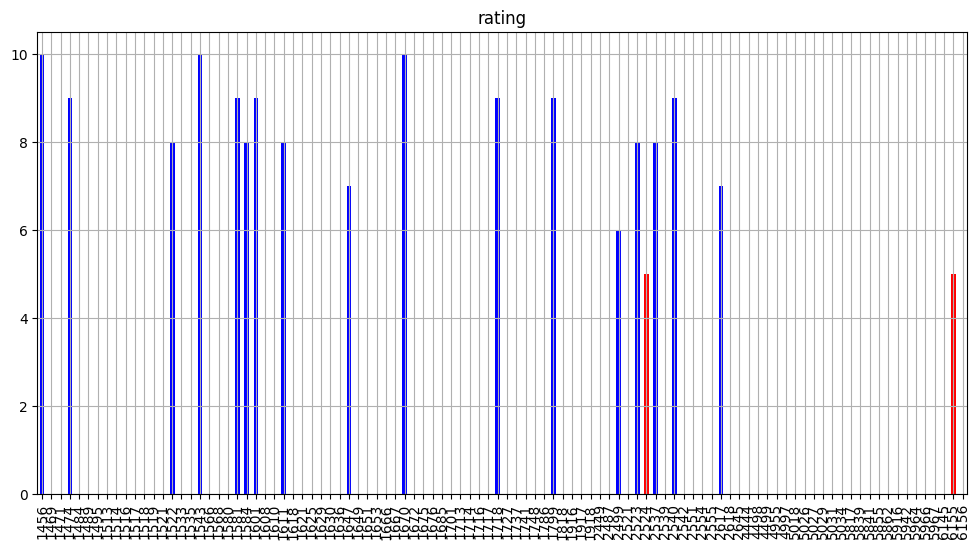

In [77]:
ratings, users = Rating_Preprocessing(ratings)

,User-ID,ISBN,Book-Rating
1456,277427,002542730X,1
1469,277427,0060930535,0
1471,277427,0060934417,0
1474,277427,0061009059,1
1484,277427,0140067477,0


<Axes: title={'center': 'rating'}>

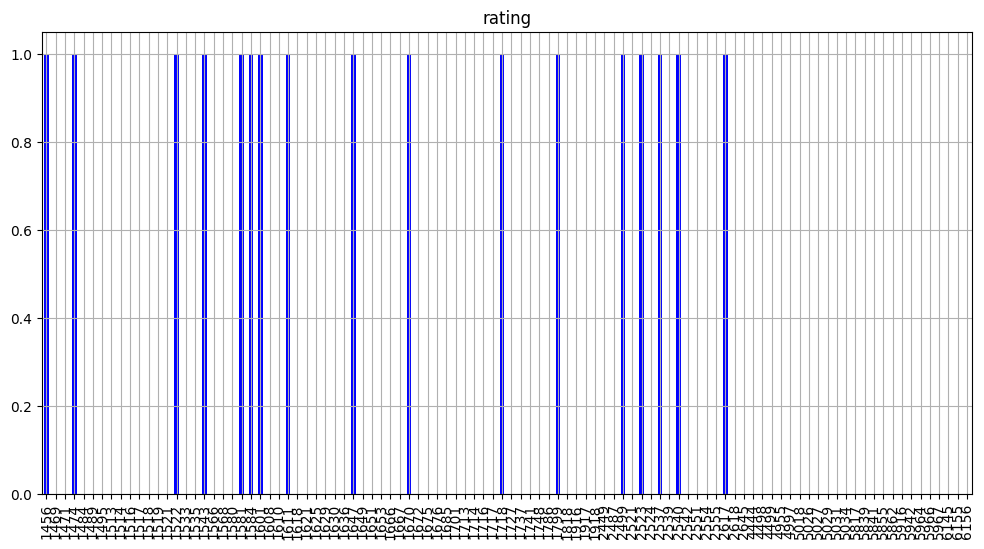

In [13]:
display(ratings.head())
fig, ax = subplots()
ratings['Book-Rating'].head(100).plot(x='record',y='rating',figsize=(12,6),
                                   title='rating', kind='bar', ax=ax, grid=True,
                                   color=np.where(ratings['Book-Rating']==1, 'b','r'))

like ratio: 0.2118132041034678
dislike ratio: 0.7881867958965322


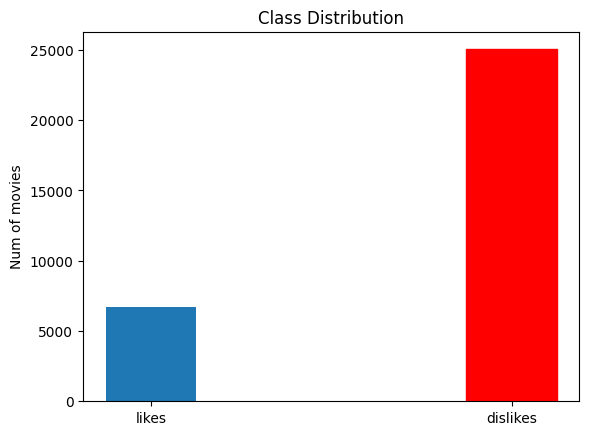

In [14]:
likes = (ratings['Book-Rating']==1).sum()
dislikes = (ratings['Book-Rating']==0).sum()
like_ratio = likes/ratings.shape[0]
dislike_ratio = 1-like_ratio
print(f'like ratio: {like_ratio}')
print(f'dislike ratio: {dislike_ratio}')
performance = [likes,dislikes]
classes = ('likes','dislikes')
x = plt.bar(classes, performance, width=0.25,align='center')
x[1].set_color('r')
plt.xticks(classes)
plt.ylabel('Num of movies')
plt.title('Class Distribution')
plt.show()

In [15]:
books = pd.read_csv('./Book_Recommender/BX_Books.csv',sep= ';', encoding = 'latin-1')
#,header=None, names=['ISBN','Book-Title','Book-Author','Year-Of-Publication','Publisher','Image-URL-S','Image-URL-M','Image-URL-L'],skiprows=250000
print(f'number of books: {books.shape[0]} \nnumber of features: {books.shape[1]}')
print(books.isnull().sum())
books.head()
#check = (movies['genres']=='(no genres listed)').sum()
#check

number of books: 271379 
number of features: 8
ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
dtype: int64


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


In [16]:
print(len(books['Publisher'].unique()))
print(len(books['Book-Author'].unique()))
books['Year-Of-Publication'].unique()

16807
102028


array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984,    0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, 2012, 2006, 1909, 2008, 1378,
       1919, 1922, 1897, 2024, 1376, 2037], dtype=int64)

In [17]:
books = books.drop(books[books['Year-Of-Publication'] == 0].index)
books.drop(['Publisher','Book-Author','Image-URL-S','Image-URL-M','Image-URL-L'],axis=1,inplace=True)

In [18]:
def Books_Preprocessing(books):
    tqdm.pandas(desc="Processing books")

    # Calculate min and max only once
    min_year = books['Year-Of-Publication'].min()
    max_year = books['Year-Of-Publication'].max()
    year_range = max_year - min_year

    # Vectorized normalization
    books['Year-Normalized'] = books['Year-Of-Publication'].apply(
        lambda x: '' if x == '' else round((float(x - min_year) / year_range), 3)
    )

    # Vectorized scaling
    books['Scaled-Year'] = books['Year-Of-Publication'].apply(
        lambda x: 1 if x < 1920 else 2 if x < 1970 else 3
    )

    return books


In [19]:
books = Books_Preprocessing(books)
books.head()

,ISBN,Book-Title,Year-Of-Publication,Year-Normalized,Scaled-Year
0,0195153448,Classical Mythology,2002,0.929,3
1,0002005018,Clara Callan,2001,0.927,3
2,0060973129,Decision in Normandy,1991,0.912,3
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,1999,0.924,3
4,0393045218,The Mummies of Urumchi,1999,0.924,3


In [20]:
comb_data = ratings[['User-ID','ISBN','Book-Rating']].merge(books[['ISBN','Book-Title','Year-Normalized','Scaled-Year']],on='ISBN',how='inner')
comb_data['Book-Rating'].unique()

array([1, 0], dtype=int64)

In [21]:
comb_data

,User-ID,ISBN,Book-Rating,Book-Title,Year-Normalized,Scaled-Year
0,277427,002542730X,1,Politically Correct Bedtime Stories: Modern Tales for Our Life and Times,0.917,3
1,277427,0060930535,0,The Poisonwood Bible: A Novel,0.924,3
2,277427,0060934417,0,Bel Canto: A Novel,0.929,3
3,277427,0061009059,1,One for the Money (Stephanie Plum Novels (Paperback)),0.918,3
4,277427,0140067477,0,The Tao of Pooh,0.901,3
...,...,...,...,...,...,...
31537,275970,0684874350,0,ANGELA'S ASHES,0.920,3
31538,275970,0743412028,0,Pay It Forward,0.926,3
31539,275970,0804111359,0,Secret History,0.915,3
31540,275970,1400031354,0,Tears of the Giraffe (No.1 Ladies Detective Agency),0.929,3


# Decision Tree

In [22]:
f1scores =[0,0,0,0,0]

In [23]:
def DecisionTree(av,ratings,data):
    x_train,x_test,y_train,y_test = train_test_split(data,ratings,test_size=0.2,random_state=42)
    DTrecall,DTprecision,DTf1score,estim,trainingTime,predictionTime = fit_model(x_train,x_test,y_train,y_test,av)

    return DTrecall,DTprecision,DTf1score,estim,trainingTime,predictionTime
def fit_model(x_train,x_test,y_train,y_test,av):
    cv_sets = ShuffleSplit(n_splits=10,test_size=0.1,random_state=42)
    model = DecisionTreeClassifier(random_state=42)

    max_depth = range(1,22)
    params = dict(max_depth=max_depth)

    grid = GridSearchCV(model,params,scoring=None,cv=cv_sets)
    t0=time.time()
    grid=grid.fit(x_train,y_train)
    trainingTime = round(time.time()-t0,3)

    t0=time.time()
    y_pred=grid.predict(x_test)
    predictionTime = round(time.time()-t0,3)
    

    return (round(recall_score(y_test,y_pred,average=av),2)),(round(precision_score(y_test,y_pred,average=av),2)),(round(f1_score(y_test,y_pred,average=av),2)),grid.best_estimator_,trainingTime,predictionTime

In [24]:
DTf1scores=[]
DTdata= pd.DataFrame(ratings[['User-ID','Book-Rating','ISBN']].merge(books[['ISBN','Book-Title','Year-Normalized','Scaled-Year']],on='ISBN',how='inner'))
ratingsonly = DTdata['Book-Rating']
DTdata.drop(['ISBN','Book-Rating','Book-Title'],axis=1,inplace=True)

DTrecall,DTprecision,DTf1score,reg,trainingTime,predictionTime=DecisionTree('micro',ratingsonly,DTdata)
DTf1scores.append(DTf1score)

In [25]:
DTrecall,DTprecision,DTf1score,reg,trainingTime,predictionTime

(0.8,
 0.8,
 0.8,
 DecisionTreeClassifier(max_depth=3, random_state=42),
 4.469,
 0.0)

In [26]:
DTrecall,DTprecision,DTf1score,reg,trainingTime,predictionTime=DecisionTree('weighted',ratingsonly,DTdata)
DTf1scores.append(DTf1score)

In [27]:
DTrecall,DTprecision,DTf1score,reg,trainingTime,predictionTime

(0.8,
 0.77,
 0.72,
 DecisionTreeClassifier(max_depth=3, random_state=42),
 4.307,
 0.006)

In [28]:
f1scores[0]=max(DTf1scores)
f1scores[0]

0.8

# KNN Classifier

In [29]:
total_fit_time,total_predict_time = 0,0
def KNNclassifier(users,NNdata,av):
    global total_fit_time,total_predict_time
    

    f1score,recall,precision=0,0,0
    for userId in tqdm(users):
        userNNdata = NNdata.loc[NNdata['User-ID'] == userId]
        ratings = userNNdata['Book-Rating']
        del userNNdata['Book-Rating'],userNNdata['User-ID']

        if len(userNNdata) < 2:
            continue
        f1score_user,recall_user,precision_user = KNN(userNNdata,ratings,av)
        f1score+=f1score_user
        recall+=recall_user
        precision+=precision_user

    return (round((float(recall)/len(users)),2)),(round((float(precision)/len(users)),2)),(round((float(f1score)/len(users)),2))

def KNN(userNNdata,ratings,av):
    global total_fit_time,total_predict_time

    x_train,x_test,y_train,y_test = train_test_split(userNNdata,ratings,test_size=0.2,random_state=42)
    n_neighbors = min(5, len(x_train))
    neighbors = KNeighborsClassifier(n_neighbors=n_neighbors,weights='uniform')
    
    t0=time.time()
    neighbors.fit(x_train,y_train)
    total_fit_time+=time.time()-t0
    t0=time.time()
    y_pred=neighbors.predict(x_test)
    total_predict_time+=time.time()-t0

    return f1_score(y_test,y_pred,average=av,zero_division=0),recall_score(y_test,y_pred,average=av,zero_division=0),precision_score(y_test,y_pred,average=av,zero_division=0)

In [30]:
KNNf1scores = []
NNdata = ratings[['User-ID','Book-Rating','ISBN']].merge(books[['ISBN','Book-Title','Year-Of-Publication']], on='ISBN',how='inner')
users = np.unique(NNdata['User-ID'])
NNdata.drop(['ISBN','Book-Title'], axis=1,inplace=True)
KNNrecall,KNNprecision,KNNf1score = KNNclassifier(users,NNdata,'micro')

100%|███████████████████████████████████████████████████████████████████████████████| 688/688 [00:03<00:00, 203.64it/s]


In [31]:
KNNf1scores.append(KNNf1score)
KNNrecall,KNNprecision,KNNf1score,total_fit_time,total_predict_time

(0.74, 0.74, 0.74, 0.449199914932251, 0.7777318954467773)

In [32]:
KNNrecall,KNNprecision,KNNf1score = KNNclassifier(users,NNdata,'weighted')

100%|███████████████████████████████████████████████████████████████████████████████| 688/688 [00:03<00:00, 210.66it/s]


In [33]:
KNNf1scores.append(KNNf1score)
KNNrecall,KNNprecision,KNNf1score,total_fit_time,total_predict_time

(0.74, 0.69, 0.7, 0.9081571102142334, 1.5784962177276611)

In [34]:
f1scores[1] = max(KNNf1scores)

# Random Forest

In [35]:
def RandomForest(ratings,RFdata,av):
    x_train,x_test,y_train,y_test = train_test_split(RFdata, ratings, test_size=0.2)
    model = RandomForestClassifier(n_jobs=10,max_features=None)
    t0=time.time()
    model.fit(x_train,y_train)
    trainingTIme=time.time()-t0

    t0=time.time()
    y_pred = model.predict(x_test)
    predictionTime = time.time()-t0

    return (round(recall_score(y_test,y_pred,average=av),2)),(round(precision_score(y_test,y_pred,average=av),2)),(round(f1_score(y_test,y_pred,average=av),2)),trainingTime,predictionTime

In [36]:
RFf1scores=[]
RFdata = ratings[['User-ID','Book-Rating','ISBN']].merge(books[['ISBN','Book-Title','Year-Of-Publication']],on='ISBN',how='inner')
ratingsonly = RFdata['Book-Rating']
RFdata.drop(['Book-Rating','ISBN','Book-Title'],axis=1,inplace=True)
RFrecall,RFprecision,RFf1score,trainingTime,predictionTime = RandomForest(ratingsonly,RFdata,'micro')

In [37]:
RFf1scores.append(RFf1score)
RFrecall,RFprecision,RFf1score,trainingTime,predictionTime

(0.75, 0.75, 0.75, 4.307, 0.027612924575805664)

In [38]:
RFrecall,RFprecision,RFf1score,trainingTime,predictionTime = RandomForest(ratingsonly,RFdata,'weighted')
RFf1scores.append(RFf1score)

In [39]:
RFrecall,RFprecision,RFf1score,trainingTime,predictionTime

(0.76, 0.73, 0.74, 4.307, 0.025473833084106445)

In [ ]:
f1scores[2]=max(RFf1scores)

# Light GBM

In [41]:
def lightGBM(GBMdata,users,av):
    recall,precision,f1score=0,0,0
    trainingTime,predictionTime=0,0
    for userId in tqdm(users):
        userGBMdata = GBMdata.loc[GBMdata['User-ID']==userId]
        ratings = userGBMdata['Book-Rating']
        del userGBMdata['ISBN'], userGBMdata['Book-Rating'], userGBMdata['User-ID'],

        if len(userGBMdata) < 2:
            continue

        userf1score,userrecall,userprecision=0,0,0
        for i in range(0,10):
            x_train,x_test,y_train,y_test = train_test_split(userGBMdata,ratings,test_size=0.2,random_state=42)

            sc =StandardScaler()
            x_train = sc.fit_transform(x_train)
            x_test= sc.transform(x_test)
            d_train = lgb.Dataset(x_train,label=y_train)
            
            params = {}
            params['learning_rate'] = 0.003
            params['boosting_type'] = 'gbdt'
            params['objective'] = 'binary'
            params['metric'] = 'binary_logloss'
            params['sub_feature'] = 0.8
            params['num_leaves'] = 20
            params['max_depth'] = -1
            params['min_data_in_leaf']=5

            t0 = time.time()
            model = lgb.train(params,d_train, 100)
            trainingTime+=time.time()-t0

            t0 = time.time()
            y_pred = model.predict(x_test)
            predictionTime+=time.time()-t0

            y_predlist=[0 if y<0.5 else 1 for y in y_pred]

            cm = confusion_matrix(y_test,y_predlist)
            userf1score += f1_score(y_predlist,y_test,average=av)
            userrecall+=recall_score(y_predlist,y_test,average=av)
            userprecision+=precision_score(y_predlist,y_test,average=av)

        userf1score/=10
        userrecall/=10
        userprecision/=10
        f1score+=userf1score
        recall+=userrecall
        precision+=userprecision


    return (round((float(recall)/len(users)),2)),(round((float(precision)/len(users)),2)),(round((float(f1score)/len(users)),2)),trainingTime,predictionTime
    

In [42]:
GBMf1scores=[]
GBMdata = ratings[['User-ID','Book-Rating','ISBN']].merge(books[['ISBN','Year-Of-Publication']], on='ISBN',how='inner')
users = np.unique(GBMdata['User-ID'])

In [ ]:
GBMrecall,GBMprecision,GBMf1score,trainingTime,predictionTime = lightGBM(GBMdata,users,'micro')
GBMf1scores.append(GBMf1score)

In [44]:
GBMrecall,GBMprecision,GBMf1score,trainingTime,predictionTime

(0.76, 0.76, 0.76, 35.691152811050415, 0.685927152633667)

In [ ]:
GBMrecall,GBMprecision,GBMf1score,trainingTime,predictionTime = lightGBM(GBMdata,users,'weighted')
GBMf1scores.append(GBMf1score)

In [46]:
GBMrecall,GBMprecision,GBMf1score,trainingTime,predictionTime

(0.76, 0.93, 0.82, 34.99125337600708, 0.6577610969543457)

In [54]:
f1scores[3]=max(GBMf1scores)
f1scores

[0.8, 0.74, 0.75, 0.82, 0]

In [78]:
def CollaborativeFiltering(ratings):
    preferences={}
    for index,record in ratings.iterrows():
        if int(record['User-ID']) in preferences.keys():
            preferences[int(record['User-ID'])][record['ISBN']]=int(record['Book-Rating'])
        else:
            preferences[int(record['User-ID'])]={}
            preferences[int(record['User-ID'])][record['ISBN']]=int(record['Book-Rating'])
    return preferences
def similarity_distance(preferences,user1,user2):
    shared_items={}
    for item in preferences[user1]:
        if item in preferences[user2]:
            shared_items[item]=1
        if len(shared_items)==0:
            return 0
    sum_of_squares=sum([pow(preferences[user1][item]-preferences[user2][item],2) for item in shared_items.keys()])

    return 1.0/(1.0+sum_of_squares)

In [79]:
def getRecommendations(preferences,person,av,similarity=similarity_distance):
    scores,ratings=[],[]
    recall,precision,f1score=0,0,0
    for item in preferences[person]:
        totals={}
        similarity_sums={}
        for other in preferences:
            if other==person:
                continue
            sim=similarity(preferences,person,other)
            if sim<=0:
                continue
            if item in preferences[other]:
                totals.setdefault(item,0)
                totals[item]+=preferences[other][item]*sim
                similarity_sums.setdefault(item,0)
                similarity_sums[item]+=sim
        if item in totals:
            scores.append(1 if totals[item]/similarity_sums[item]>=3.0 else 0)
            ratings.append(1 if preferences[person][item]>=3.0 else 0)

    CFf1score = f1_score(scores,ratings,average=av,zero_division=0)
    CFrecall = recall_score(scores,ratings,average=av, zero_division=0)
    CFprecision = precision_score(scores,ratings,average=av, zero_division=0)
    return CFrecall,CFprecision,CFf1score

In [80]:
preferences=CollaborativeFiltering(ratings)
CFf1scores=[]
CFf1score,CFrecall,CFprecision=0,0,0
user_precision,user_recall,user_f1score=0,0,0
for user in tqdm(users):
    p,r,f=getRecommendations(preferences,user,'micro',similarity=similarity_distance)
    user_precision+=p
    user_recall+=r
    user_f1score+=f
CFf1score = user_f1score/len(users)
CFrecall = user_recall/len(users)
CFprecision = user_precision/len(users)

CFf1score,CFrecall,CFprecision

100%|████████████████████████████████████████████████████████████████████████████████| 688/688 [00:29<00:00, 23.68it/s]


(1.0, 1.0, 1.0)

In [81]:
f1scores[4]=round(CFf1score,2)

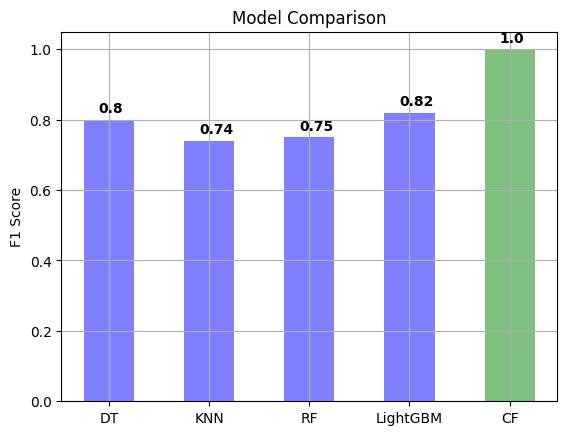

In [86]:
classes=('DT','KNN','RF','LightGBM','CF')
plt.bar(classes,f1scores,width=0.5,align='center',color=['g' if x==max(f1scores) else 'b' for x in f1scores],alpha=0.5)
plt.grid()
plt.ylabel('F1 Score')
plt.title('Model Comparison')
for i,v in enumerate(f1scores):
    plt.text(i-0.1, v+0.02,str(v),color='black',fontweight='bold')
plt.show()

In [83]:
models=list(classes)
sorted_f1scores_list = sorted(zip(models,f1scores), key =( lambda pair: pair[1]),reverse=True)
sorted_f1scores_list

[('CF', 1.0), ('LightGBM', 0.82), ('DT', 0.8), ('RF', 0.75), ('KNN', 0.74)]